# Homework #8 Answers

## Chongye Feng

In [6]:
# importing libraries
import numba
import numpy as np
import pandas as pd
from pylab import *
from mpl_toolkits.mplot3d import axes3d
from scipy.optimize import minimize

import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.decomposition import PCA

# setting the random seed
np.random.seed(0)

----

### a:

In [7]:
import pickle


with open('mnist.pkl', 'rb') as f:
    data = pickle.load(f)

In [8]:
train_x, train_y, test_x, test_y = data[0][0], data[0][1], data[1][0], data[1][1]

In [9]:
def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(12, 12),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(32, 32), cmap='binary')
        im.set_clim(0, 16)

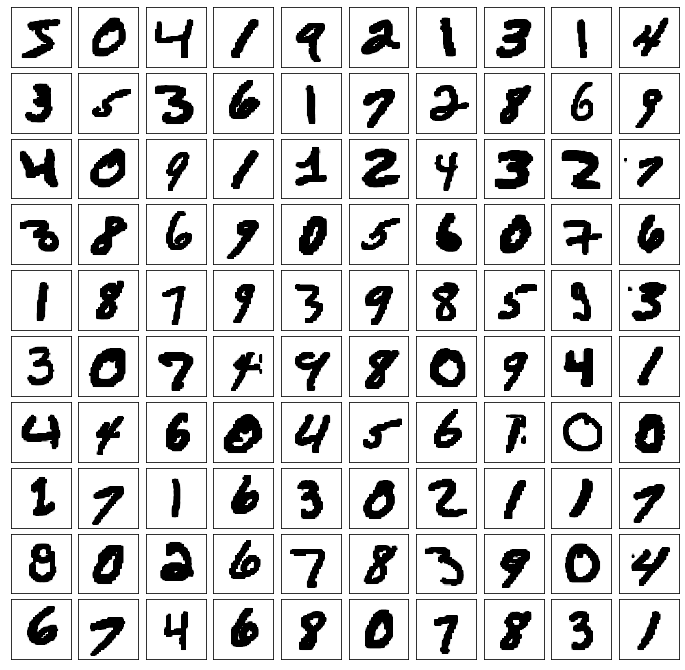

In [10]:
plot_digits(train_x)

In [15]:
train_x = train_x / np.max(train_x)
test_x = test_x / np.max(test_x)

$$
H_{\text {out }}=\left[\frac{H_{\text {in }}+2 \times \text { padding }-\operatorname{dilation} \times(\text { kernel_size }-1)-1}{\text { stride }}+1\right]
$$

#### i

$H = (32 + 2 * 0 - 2) / 2 + 1 = 16$

$W = (32 + 2 * 0 - 2) / 2 + 1 = 16$

$D = 33$

#### ii

$H = (32 + 2 * 1 - 3) / 1 + 1 = 32$

$W = (32 + 2 * 1 - 3) / 1 + 1 = 32$

$D = 55$

#### iii

Before Max Pooling:

$H = (32 + 2 * 1 - 3) / 1 + 1 = 32$

$W = (32 + 2 * 1 - 3) / 1 + 1 = 32$

$D = 77$

Max Pooling:

$H = (32 - 2) / 2 + 1 = 16$

$W = (32 - 2) / 2 + 1 = 16$

$D = 77$

---

### b:

I believe that the depth of the input does not necessarily determine the depth of the output, as the depth of the filter can be adjusted to match the input depth. For instance, if the input depth is 3, it is possible to have a filter depth of 3, resulting in the output depth being the same as the input depth. This would mean that the number of filters would also determine the depth of the output.

Alternatively, since the question does not specify and there is uncertainty about the accuracy of the above statement, it could be rephrased as follows:

If the filter is limited to a 2D configuration, then the depth of the output would be determined by multiplying the number of filters by the depth of the input. For instance, if the input depth is 3 (representing RGB channels) and there are 33 filters, the resulting output depth would be 99.

#### i

$(D, W, H) = (16, 16, 33) or (16, 16, 99)$

#### ii

$(D, W, H) = (32, 32, 55) or (32, 32, 165)$

#### iii

$(D, W, H) = (16, 16, 77) or (16, 16, 231)$

---

### c:

All the Functions and Classes:

In [11]:
from functools import wraps
from time import time

def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        ts = time()
        result = f(*args, **kw)
        te = time()
        print('func:%r  took: %2.4f sec' % (f.__name__,  te-ts))
        return result
    return wrap

In [27]:
from torch.optim import SGD, Adam
import torch.nn.functional as F
import random
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split

def create_chunks(complete_list, chunk_size=None, num_chunks=None):
    '''
    Cut a list into multiple chunks, each having chunk_size (the last chunk might be less than chunk_size) or having a total of num_chunk chunks
    '''
    chunks = []
    if num_chunks is None:
        num_chunks = math.ceil(len(complete_list) / chunk_size)
    elif chunk_size is None:
        chunk_size = math.ceil(len(complete_list) / num_chunks)
    for i in range(num_chunks):
        chunks.append(complete_list[i * chunk_size: (i + 1) * chunk_size])
    return chunks

class Trainer():
    def __init__(self, model, optimizer_type, learning_rate, epoch, batch_size, input_transform=lambda x: x,):
        """ The class for training the model
        model: nn.Module
            A pytorch model
        optimizer_type: 'adam' or 'sgd'
        learning_rate: float
        epoch: int
        batch_size: int
        input_transform: func
            transforming input. Can do reshape here
        """
        self.model = model
        if optimizer_type == "sgd":
            self.optimizer = SGD(model.parameters(), learning_rate,momentum=0.9)
        elif optimizer_type == "adam":
            self.optimizer = Adam(model.parameters(), learning_rate)
            
        self.epoch = epoch
        self.batch_size = batch_size
        self.input_transform = input_transform


    @timing
    def train(self, inputs, outputs, val_inputs, val_outputs,early_stop=False,l2=False,silent=False):
        """ train self.model with specified arguments
        inputs: np.array, The shape of input_transform(input) should be (ndata,nfeatures)
        outputs: np.array shape (ndata,)
        val_nputs: np.array, The shape of input_transform(val_input) should be (ndata,nfeatures)
        val_outputs: np.array shape (ndata,)
        early_stop: bool
        l2: bool
        silent: bool. Controls whether or not to print the train and val error during training
        
        @return
        a dictionary of arrays with train and val losses and accuracies
        """
        ### convert data to tensor of correct shape and type here ###
        inputs = self.input_transform(torch.tensor(inputs, dtype=torch.float))
        outputs = torch.tensor(outputs, dtype=torch.int64)
        val_inputs = self.input_transform(torch.tensor(val_inputs, dtype=torch.float))
        val_outputs = torch.tensor(val_outputs, dtype=torch.int64)
        
        losses = []
        accuracies = []
        val_losses = []
        val_accuracies = []
        weights = self.model.state_dict()
        lowest_val_loss = np.inf
        
        for n_epoch in tqdm(range(self.epoch), leave=False):
            self.model.train()
            batch_indices = list(range(inputs.shape[0]))
            random.shuffle(batch_indices)
            batch_indices = create_chunks(batch_indices, chunk_size=self.batch_size)
            epoch_loss = 0
            epoch_acc = 0
            for batch in batch_indices:
                batch_importance = len(batch) / len(outputs)
                batch_input = inputs[batch]
                batch_output = outputs[batch]
                ### make prediction and compute loss with loss function of your choice on this batch ###
                batch_predictions = self.model(batch_input)
                loss = nn.CrossEntropyLoss()(batch_predictions, batch_output)
                if l2:
                    ### Compute the loss with L2 regularization ###
                    l2_lambda = 1e-5
                    l2_norm = sum(p.pow(2.0).sum() for p in self.model.parameters())
                    loss = loss + l2_lambda * l2_norm
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                ### Compute epoch_loss and epoch_acc
                epoch_loss += loss.detach().cpu().item() * batch_importance
                acc = torch.sum(torch.argmax(batch_predictions, axis=-1) == batch_output) / len(batch_predictions)
                epoch_acc += acc.detach().cpu().item() * batch_importance
            val_loss, val_acc = self.evaluate(val_inputs, val_outputs, print_acc=False)
            if n_epoch % 10 ==0 and not silent: 
                print("Epoch %d/%d - Loss: %.3f - Acc: %.3f" % (n_epoch + 1, self.epoch, epoch_loss, epoch_acc))
                print("              Val_loss: %.3f - Val_acc: %.3f" % (val_loss, val_acc))
            losses.append(epoch_loss)
            accuracies.append(epoch_acc)
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)
            if early_stop:
                if val_loss < lowest_val_loss:
                    lowest_val_loss = val_loss
                    weights = self.model.state_dict()

        if early_stop:
            self.model.load_state_dict(weights)    

        return {"losses": losses, "accuracies": accuracies, "val_losses": val_losses, "val_accuracies": val_accuracies}
        
    def evaluate(self, inputs, outputs, print_acc=True):
        """ evaluate model on provided input and output
        inputs: np.array, The shape of input_transform(input) should be (ndata,nfeatures)
        outputs: np.array shape (ndata,)
        print_acc: bool
        
        @return
        losses: float
        acc: float
        """
        if torch.is_tensor(inputs):
            inputs = self.input_transform(inputs)
        else:
            inputs = self.input_transform(torch.tensor(inputs, dtype=torch.float))
            outputs = torch.tensor(outputs, dtype=torch.int64)
        self.model.eval()
        batch_indices = list(range(inputs.shape[0]))
        batch_indices = create_chunks(batch_indices, chunk_size=self.batch_size)
        acc = 0
        losses = 0
        for batch in batch_indices:
            batch_importance = len(batch) / len(outputs)
            batch_input = inputs[batch]
            batch_output = outputs[batch]
            with torch.no_grad():
                batch_predictions = self.model(batch_input)
                loss = nn.CrossEntropyLoss()(batch_predictions, batch_output)
            batch_acc = torch.sum(torch.argmax(batch_predictions, axis=-1) == batch_output) / len(batch_predictions)
            losses += loss.detach().cpu().item() * batch_importance
            acc += batch_acc.detach().cpu().item() * batch_importance
        if print_acc:
            print("Accuracy: %.3f" % acc)
        return losses, acc

In [28]:
from torch import nn
import torch
class Net_C(nn.Module):
    def __init__(self):
        super(Net_C, self).__init__()
        self.conv = nn.ModuleList([
            nn.Conv2d(in_channels=1, out_channels=3, kernel_size=5, stride=1, padding=2)   # (32 + 2*2 -5) / 1 + 1 = 32
        ])
                
        self.fc = nn.ModuleList([
            nn.Linear(32 * 32 * 3, 10)
        ])
        
        self.activation = nn.ReLU()
        
    def forward(self, x):
        x = x.view(-1, 1, 32, 32)
        x = self.activation(self.conv[0](x))
        x = nn.Flatten()(x)
        x = self.activation(self.fc[0](x))
        x = nn.Softmax(dim=-1)(x)
        return x

In [16]:
from sklearn.model_selection import train_test_split,KFold
def Kfold(model_func,k,Xs,ys,test_Xs,test_ys,epochs,draw_curve=True,early_stop=False,batchsize=128, optimizer='adam',lr=1e-3,l2=False,
          input_shape=(-1,1024)):
    """ Do Kfold cross validation with the specified arguments
    model_func: function. 
        Constructor of the model.
    k: int. The number of fold
    Xs: np.array, The shape of Xs.reshape(input_shape) should be (ndata,nfeatures)
    ys: np.array shape (ndata,)
    test_Xs: np.array, The shape of test_Xs.reshape(input_shape) should be (ndata,nfeatures)
    test_ys: np.array shape (ndata,)
    epoch: int
    batch_size: int
    early_stop: bool
    lr: float. learning_rate
    l2: bool
    optimizer: 'adam' or 'sgd'
    input_shape: tuple
    """
    # The total number of examples for training the network
    total_num=len(Xs)
    # Built in K-fold function in Sci-Kit Learn
    kf=KFold(n_splits=k,shuffle=True)
    train_acc_all=[]
    test_acc_all=[]
    fold=0
    for train_selector,val_selector in kf.split(range(total_num)):
        fold+=1
        print(f'Fold #{fold}')
        
        train_Xs=Xs[train_selector]
        val_Xs=Xs[val_selector]
        train_ys=ys[train_selector]
        val_ys=ys[val_selector]
        
        model=model_func()
        if fold ==1:
            print(f"{model_func.__name__} parameters:", sum([len(item.flatten()) for item in model.parameters()]))
            
        trainer = Trainer(model, optimizer, lr, epochs, batchsize, lambda x: x.reshape(input_shape))
        log=trainer.train(train_Xs, train_ys,val_Xs,val_ys,early_stop=early_stop,l2=l2)
        
        if draw_curve:
            plt.figure()
            plt.plot(log["losses"], label="losses")
            plt.plot(log["val_losses"], label="validation_losses")
            plt.legend()
            plt.title(f'Fold #{fold} loss')

            plt.figure()
            plt.plot(log["accuracies"], label="accuracies")
            plt.plot(log["val_accuracies"], label="validation_accuracies")
            plt.legend()
            plt.title(f'Fold #{fold} accuracy')
        
        # Report result for this fold
        if early_stop:
            report_idx= np.argmin(log["val_losses"])      
        else:
            report_idx=-1
        test_acc=trainer.evaluate(test_Xs,test_ys,print_acc=False)[1]
        train_acc_all.append(log["accuracies"][report_idx])
        test_acc_all.append(test_acc)
        print("Train accuracy:",log["accuracies"][report_idx])
        print("Validation accuracy:",log["val_accuracies"][report_idx])
        print("Test accuracy:",test_acc)
        
    print("Final results:")
    print("Training accuracy:%f+-%f"%(np.average(train_acc_all),np.std(train_acc_all)))
    print("Testing accuracy:%f+-%f"%(np.average(test_acc_all),np.std(test_acc_all)))

In [17]:
from sklearn.model_selection import train_test_split,KFold
def train_model(model_func,Xs,ys,test_Xs,test_ys,epochs,draw_curve=True,early_stop=False,batchsize=128, optimizer='adam',lr=1e-3,input_shape=(-1,1024)):
    train_Xs, val_Xs, train_ys, val_ys = train_test_split(Xs, ys, test_size=1/3, random_state=0)
    model=model_func()

    print(f"{model_func.__name__} parameters:", sum([len(item.flatten()) for item in model.parameters()]))
            
    trainer = Trainer(model, optimizer, lr, epochs, batchsize, lambda x: x.reshape(input_shape))
    log=trainer.train(train_Xs, train_ys,val_Xs,val_ys,early_stop=early_stop)

    if draw_curve:
        plt.figure()
        plt.plot(log["losses"], label="losses")
        plt.plot(log["val_losses"], label="validation_losses")
        plt.legend()
        plt.title(f'loss')

        plt.figure()
        plt.plot(log["accuracies"], label="accuracies")
        plt.plot(log["val_accuracies"], label="validation_accuracies")
        plt.legend()
        plt.title(f'accuracy')

    # Report result for this fold
    if early_stop:
        report_idx= np.argmin(log["val_losses"])      
    else:
        report_idx=-1
    test_acc=trainer.evaluate(test_Xs,test_ys,print_acc=False)[1]
    print("Train accuracy:",log["accuracies"][report_idx])
    print("Validation accuracy:",log["val_accuracies"][report_idx])
    print("Test accuracy:",test_acc)


In [39]:
from torchsummary import summary

model_c = Net_C()
summary(model_c, (1,32,32))

Layer (type:depth-idx)                   Output Shape              Param #
├─ModuleList: 1                          []                        --
|    └─Conv2d: 2-1                       [-1, 3, 32, 32]           78
├─ReLU: 1-1                              [-1, 3, 32, 32]           --
├─ModuleList: 1                          []                        --
|    └─Linear: 2-2                       [-1, 10]                  30,730
├─ReLU: 1-2                              [-1, 10]                  --
Total params: 30,808
Trainable params: 30,808
Non-trainable params: 0
Total mult-adds (M): 0.11
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.12
Estimated Total Size (MB): 0.14


Layer (type:depth-idx)                   Output Shape              Param #
├─ModuleList: 1                          []                        --
|    └─Conv2d: 2-1                       [-1, 3, 32, 32]           78
├─ReLU: 1-1                              [-1, 3, 32, 32]           --
├─ModuleList: 1                          []                        --
|    └─Linear: 2-2                       [-1, 10]                  30,730
├─ReLU: 1-2                              [-1, 10]                  --
Total params: 30,808
Trainable params: 30,808
Non-trainable params: 0
Total mult-adds (M): 0.11
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.12
Estimated Total Size (MB): 0.14

Fold #1
Net_C parameters: 30808


  3%|▎         | 1/30 [00:03<01:27,  3.01s/it]

Epoch 1/30 - Loss: 1.831 - Acc: 0.647
              Val_loss: 1.765 - Val_acc: 0.669


 37%|███▋      | 11/30 [00:27<00:48,  2.55s/it]

Epoch 11/30 - Loss: 1.730 - Acc: 0.692
              Val_loss: 1.734 - Val_acc: 0.687


 70%|███████   | 21/30 [00:52<00:22,  2.49s/it]

Epoch 21/30 - Loss: 1.724 - Acc: 0.697
              Val_loss: 1.731 - Val_acc: 0.688


func:'train'  took: 75.2376 sec
Train accuracy: 0.7000000000000002
Validation accuracy: 0.6893500000000001
Test accuracy: 0.6945999999999999
Fold #2


  3%|▎         | 1/30 [00:02<01:13,  2.54s/it]

Epoch 1/30 - Loss: 1.800 - Acc: 0.679
              Val_loss: 1.715 - Val_acc: 0.735


 37%|███▋      | 11/30 [00:27<00:47,  2.51s/it]

Epoch 11/30 - Loss: 1.670 - Acc: 0.768
              Val_loss: 1.669 - Val_acc: 0.769


 70%|███████   | 21/30 [00:52<00:23,  2.61s/it]

Epoch 21/30 - Loss: 1.658 - Acc: 0.778
              Val_loss: 1.661 - Val_acc: 0.776


func:'train'  took: 74.1918 sec
Train accuracy: 0.8775999999999999
Validation accuracy: 0.8715000000000003
Test accuracy: 0.8728999999999996
Fold #3


  3%|▎         | 1/30 [00:02<01:10,  2.43s/it]

Epoch 1/30 - Loss: 1.989 - Acc: 0.522
              Val_loss: 1.927 - Val_acc: 0.578


 37%|███▋      | 11/30 [00:26<00:45,  2.40s/it]

Epoch 11/30 - Loss: 1.905 - Acc: 0.584
              Val_loss: 1.897 - Val_acc: 0.589


 70%|███████   | 21/30 [00:50<00:21,  2.41s/it]

Epoch 21/30 - Loss: 1.896 - Acc: 0.591
              Val_loss: 1.889 - Val_acc: 0.595


func:'train'  took: 72.6051 sec
Train accuracy: 0.5943249999999999
Validation accuracy: 0.5999500000000003
Test accuracy: 0.5934000000000001
Final results:
Training accuracy:0.723975+-0.116883
Testing accuracy:0.720300+-0.115543


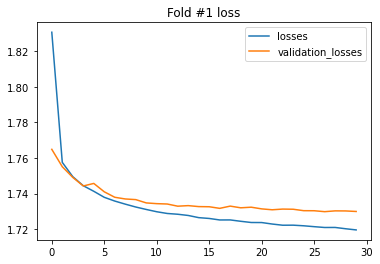

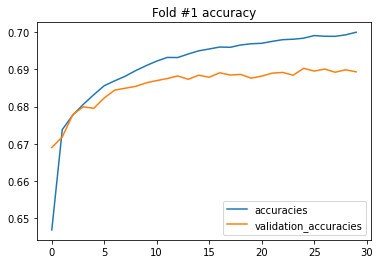

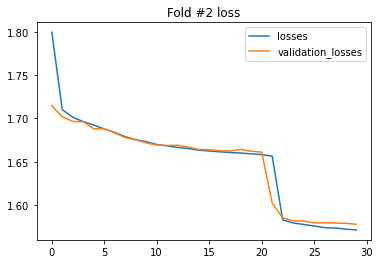

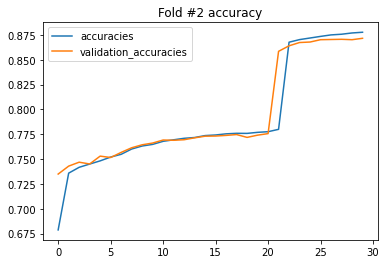

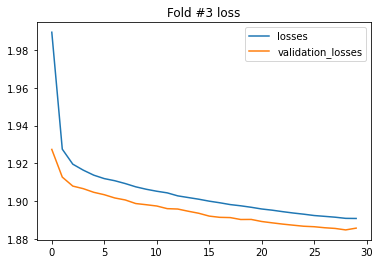

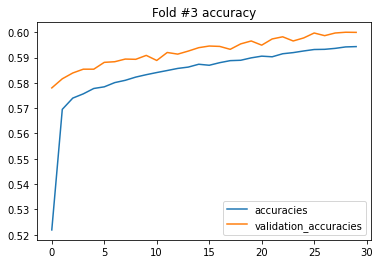

In [30]:
Kfold(Net_C,3,train_x, train_y,test_x,test_y,30,optimizer='adam')

Upon careful observation, there are no apparent signs of overfitting in this case, as the validation accuracy is comparable to the training accuracy. The training process has yielded an accuracy of approximately 72.4%, while the validation and test sets demonstrate accuracies of around 72.0%. However, it is worth noting that the testing accuracy is still relatively low, indicating a potential need for further improvements to enhance model performance. One possible approach could involve adding additional layers to the architecture in order to optimize accuracy. Further experimentation and evaluation may be necessary to determine the most effective approach for improving the model's performance.

### d:

In [62]:
class Net_D(nn.Module):
    def __init__(self):
        super(Net_D, self).__init__()
        self.conv = nn.ModuleList([
            nn.Conv2d(1, 8, kernel_size=9, stride=1),              # (8 * 24 * 24)
            nn.Conv2d(8, 32, kernel_size=7, stride=1, padding=1),   # (8 * 12 * 12) -> (32 * 8 * 8)
            nn.Conv2d(32, 64, kernel_size=6, stride=1, padding=1)   # (32 * 4 * 4) -> (64 * 1 * 1)
        ])
        
        self.pooling = nn.AvgPool2d(kernel_size=2)
        
        self.fc = nn.ModuleList([
            nn.Linear(64, 32),
            nn.Linear(32, 10)
        ])
        
        self.activation = nn.ReLU()
        
    def forward(self, x):
        x = x.view(-1, 1, 32, 32)
        x = self.pooling(self.activation(self.conv[0](x)))
        x = self.pooling(self.activation(self.conv[1](x)))
        x = self.activation(self.conv[2](x))
        x = torch.flatten(x, 1)
        x = self.activation(self.fc[0](x))
        x = nn.Softmax(dim=-1)(self.fc[1](x))
        return x

In [63]:
model_d = Net_D()
summary(model_d, (1,32,32))

Layer (type:depth-idx)                   Output Shape              Param #
├─ModuleList: 1                          []                        --
|    └─Conv2d: 2-1                       [-1, 8, 24, 24]           656
├─ReLU: 1-1                              [-1, 8, 24, 24]           --
├─AvgPool2d: 1-2                         [-1, 8, 12, 12]           --
├─ModuleList: 1                          []                        --
|    └─Conv2d: 2-2                       [-1, 32, 8, 8]            12,576
├─ReLU: 1-3                              [-1, 32, 8, 8]            --
├─AvgPool2d: 1-4                         [-1, 32, 4, 4]            --
├─ModuleList: 1                          []                        --
|    └─Conv2d: 2-3                       [-1, 64, 1, 1]            73,792
├─ReLU: 1-5                              [-1, 64, 1, 1]            --
├─ModuleList: 1                          []                        --
|    └─Linear: 2-4                       [-1, 32]                  2,080
├─R

Layer (type:depth-idx)                   Output Shape              Param #
├─ModuleList: 1                          []                        --
|    └─Conv2d: 2-1                       [-1, 8, 24, 24]           656
├─ReLU: 1-1                              [-1, 8, 24, 24]           --
├─AvgPool2d: 1-2                         [-1, 8, 12, 12]           --
├─ModuleList: 1                          []                        --
|    └─Conv2d: 2-2                       [-1, 32, 8, 8]            12,576
├─ReLU: 1-3                              [-1, 32, 8, 8]            --
├─AvgPool2d: 1-4                         [-1, 32, 4, 4]            --
├─ModuleList: 1                          []                        --
|    └─Conv2d: 2-3                       [-1, 64, 1, 1]            73,792
├─ReLU: 1-5                              [-1, 64, 1, 1]            --
├─ModuleList: 1                          []                        --
|    └─Linear: 2-4                       [-1, 32]                  2,080
├─R

Fold #1
Net_D parameters: 89434


  3%|▎         | 1/30 [00:08<04:13,  8.76s/it]

Epoch 1/30 - Loss: 1.772 - Acc: 0.697
              Val_loss: 1.645 - Val_acc: 0.819


 37%|███▋      | 11/30 [01:33<02:41,  8.53s/it]

Epoch 11/30 - Loss: 1.481 - Acc: 0.981
              Val_loss: 1.484 - Val_acc: 0.978


 70%|███████   | 21/30 [02:57<01:15,  8.42s/it]

Epoch 21/30 - Loss: 1.473 - Acc: 0.989
              Val_loss: 1.479 - Val_acc: 0.982


func:'train'  took: 253.8321 sec
Train accuracy: 0.9928750000000004
Validation accuracy: 0.9841499999999977
Test accuracy: 0.987400000000001
Fold #2


  3%|▎         | 1/30 [00:08<04:09,  8.60s/it]

Epoch 1/30 - Loss: 1.766 - Acc: 0.701
              Val_loss: 1.649 - Val_acc: 0.815


 37%|███▋      | 11/30 [01:35<02:43,  8.59s/it]

Epoch 11/30 - Loss: 1.572 - Acc: 0.889
              Val_loss: 1.573 - Val_acc: 0.888


 70%|███████   | 21/30 [02:59<01:15,  8.43s/it]

Epoch 21/30 - Loss: 1.558 - Acc: 0.902
              Val_loss: 1.563 - Val_acc: 0.897


func:'train'  took: 256.4031 sec
Train accuracy: 0.9903250000000006
Validation accuracy: 0.9847999999999981
Test accuracy: 0.9859000000000011
Fold #3


  3%|▎         | 1/30 [00:08<04:12,  8.70s/it]

Epoch 1/30 - Loss: 1.911 - Acc: 0.563
              Val_loss: 1.816 - Val_acc: 0.645


 37%|███▋      | 11/30 [01:33<02:41,  8.51s/it]

Epoch 11/30 - Loss: 1.481 - Acc: 0.981
              Val_loss: 1.482 - Val_acc: 0.980


 70%|███████   | 21/30 [02:58<01:16,  8.49s/it]

Epoch 21/30 - Loss: 1.472 - Acc: 0.989
              Val_loss: 1.476 - Val_acc: 0.985


func:'train'  took: 260.9000 sec
Train accuracy: 0.9922500000000002
Validation accuracy: 0.9851999999999976
Test accuracy: 0.9857000000000012
Final results:
Training accuracy:0.991817+-0.001085
Testing accuracy:0.986333+-0.000759


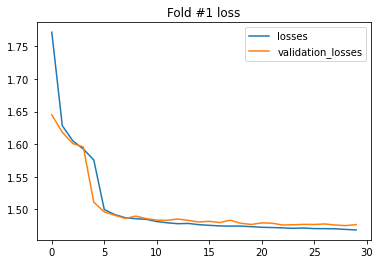

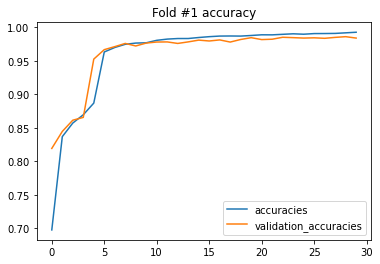

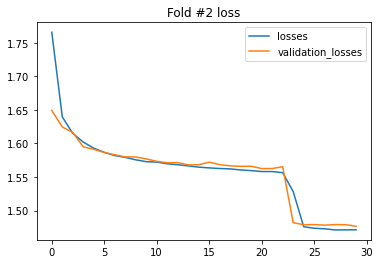

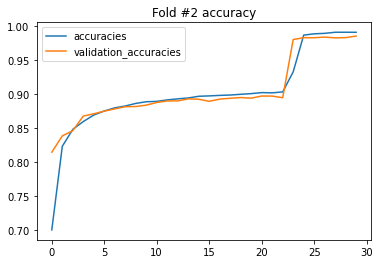

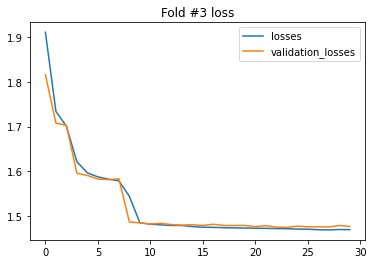

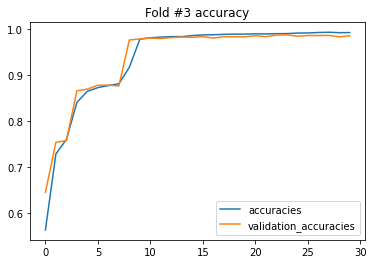

In [64]:
Kfold(Net_D,3,train_x, train_y,test_x,test_y,30,optimizer='adam')

In comparison to the previous model, this updated model demonstrates significant improvements in performance. The training accuracy has increased to an impressive 99.2%, and the test accuracy has also shown a marked improvement, reaching a threshold of 98.5%, which is 98.6%. These results suggest that the model is better able to generalize to unseen data and accurately predict outcomes.

However, it's worth noting that this increased level of performance comes at a cost in terms of time. The updated model takes approximately 2.5 times longer to train than the previous model, which could be a significant consideration depending on the specific use case and available resources. Nonetheless, the improved accuracy and ability to meet the desired threshold may outweigh the additional time cost for certain applications. Careful evaluation and consideration of both performance and computational costs can help guide the selection of the optimal model for a given task.